## Create and test ion channel model

In [13]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_inact_kin_100,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

In [2]:
modelfile = 'models/Courtemanche_iNa.mmt'

In [19]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_inact_kin_100)

In [4]:
assert len(observations)==len(summary_statistics(model({})))

In [5]:
summary_statistics(model({}))

{'0': 7.481251137429047,
 '1': 7.227415713004508,
 '2': 7.170344184357049,
 '3': 7.1522423325773055,
 '4': 7.148395196938219,
 '5': 7.148384175670795,
 '6': 7.148421540017495,
 '7': 7.148367733295623,
 '8': 7.148369795086218,
 '9': 7.148365455592815,
 '10': 7.148312599796325}

## Set limits and generate uniform initial priors

In [24]:
gate = 'j'

if gate == 'h':
    limits = {'ina.g_Na' : (0.01,100),
              'ina.c1_h': (0,50),
              'ina.a1_h': (-10,10),
              'ina.a2_h': (0,20),
              'ina.a3_h': (0,100),
              'ina.b1_h': (0,10),
              'ina.b2_h': (0,100),
              'ina.b3_h': (0,50),
              'ina.b4_h': (0,20),
              'ina.b5_h': (0.0001,1),
              'ina.b6_h': (0.000001,0.001),
              'ina.b7_h': (0,1)}

elif gate =='m':
    limits = {'ina.g_Na' : (0.01,100),
              'ina.a1_m': (0,100),
              'ina.a2_m': (-50,50),
              'ina.a3_m': (-50,50),
              'ina.a4_m': (-50,50),
              'ina.b1_m': (-50,50),
              'ina.b2_m': (0,100)}

elif gate == 'j':
    limits = {'ina.c1_j': (0,100),
              'ina.a1_j': (100000,300000),
              'log_ina.a2_j': (-4,1),
              'log_ina.a3_j': (-6,-3),
              'log_ina.a4_j': (-4,0),
              'ina.a5_j': (0,50),
              'ina.a6_j': (0.001,10),
              'ina.a7_j': (50,150),
              'ina.b1_j': (0.001,10),
              'log_ina.b2_j': (-8,-5),
              'log_ina.b3_j': (-3,1),
              'ina.b4_j': (0,50),
              'log_ina.b5_j': (-4,0),
              'log_ina.b6_j': (-4,0),
              'log_ina.b7_j': (-4,0),
              'ina.b8_j': (20,70)}

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})


In [23]:
print(limits)

{'ina.g_Na': (0.01, 100), 'ina.c1_j': (0, 100), 'ina.a1_j': (100000, 300000), 'log_ina.a2_j': (-4, 1), 'log_ina.a3_j': (-6, -3), 'log_ina.a4_j': (-4, 0), 'ina.a5_j': (0, 50), 'ina.a6_j': (0.001, 10), 'ina.a7_j': (50, 150), 'ina.b1_j': (0.001, 10), 'log_ina.b2_j': (-8, -5), 'log_ina.b3_j': (-3, 1), 'ina.b4_j': (0, 50), 'log_ina.b5_j': (-4, 0), 'log_ina.b6_j': (-4, 0), 'log_ina.b7_j': (-4, 0), 'ina.b8_j': (20, 70)}


## Run ABC calibration

In [7]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "crm_ina_testing_gate_"+gate+".db"))

In [8]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [9]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 131072 particles


In [29]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=1),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9999999999999999, '1': 0.9999999999999999, '2': 0.9999999999999999, '3': 0.9999999999999999, '4': 0.9999999999999999, '5': 0.9999999999999999, '6': 0.9999999999999999, '7': 0.9999999999999999, '8': 0.9999999999999999, '9': 0.9999999999999999, '10': 0.9999999999999999, '11': 0.9999999999999999}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=1, quantile_multiplier=1


In [30]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [31]:
abc.load(db_path,3)

3

In [58]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=3, start_time=2019-08-23 10:45:07.148250, end_time=None)>


In [32]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:10 eps:1
DEBUG:ABC:now submitting population 10
DEBUG:ABC:population 10 done
DEBUG:ABC:
total nr simulations up to t =10 is 7026234
DEBUG:Epsilon:new eps, t=11, eps=0.9392317151225115
INFO:History:Done <ABCSMC(id=3, start_time=2019-08-22 10:29:23.438224, end_time=2019-08-26 16:30:52.148221)>


# Results analysis

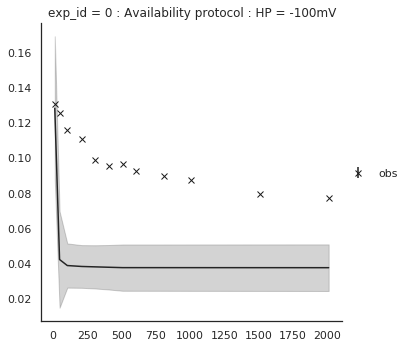

In [33]:
history = History(db_path)
history.id = 3 # 2 correponds to the recovery curve : j gate
# 3 : correponds to the availability (inact_kin_80) : j gate, but failed to retrieve a correct curve
# 5 : correponds to the availability (inact_kin_80) : m gate, still running :
# stoped after 3h without improvement (128 particles and still submitting population 0)
# 3 : correponds to the availability (inact_kin_80) : h gate, still running : stopped 


df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,sakakibara_inact_kin_100 ,df=df, w=w) 
#grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [22]:
#grid1.savefig('results/Ina Crm model/ina_crm_exp_availability_saka_pop_10000.pdf')
#grid2.savefig('results/Ina Crm model/ina_crm_post_availability_saka_pop_10000.pdf')